# 深層学習体験会: AI画像編集（Instruct-Pix2Pix）

このノートブックでは、**Instruct-Pix2Pix**モデルを使って、テキスト指示で画像を編集する方法を学びます。

## Instruct-Pix2Pixとは？

**Instruct-Pix2Pix**は、自然言語の指示に従って画像を編集するAIモデルです。「サイボーグに変えて」「背景を暗くして」などの指示を与えるだけで、自動的に画像を編集できます。

## このノートブックの流れ
1. Google Driveの接続
2. 必要なライブラリのインストール
3. モデルの読み込み
4. サンプル画像で編集を試す
5. 自分の画像で編集を試す

**注意**: このノートブックはT4 GPUの使用します。

## ステップ1: Google Driveの接続とフォルダ作成

Google Driveに接続して、編集したい画像を保存するフォルダを作成します。

In [1]:
# Google Driveをマウント（接続）する
from google.colab import drive
import os

# Google Driveに接続（初回は認証が必要です）
drive.mount('/content/drive')

# 画像を保存するディレクトリのパス
images_dir = "/content/drive/MyDrive/images"

# ディレクトリが存在しない場合は作成する（exist_ok=Trueで既存の場合はエラーにしない）
os.makedirs(images_dir, exist_ok=True)

# 画像を保存するディレクトリのパス
images_dir = "/content/drive/MyDrive/images/07"

# ディレクトリが存在しない場合は作成する（exist_ok=Trueで既存の場合はエラーにしない）
os.makedirs(images_dir, exist_ok=True)

# 作成完了メッセージを表示
print("✅ フォルダ作成:", images_dir)

Mounted at /content/drive
✅ フォルダ作成: /content/drive/MyDrive/images/07


## ステップ2: 必要なライブラリのインストール

画像編集に必要なライブラリをインストールします:
- **diffusers**: Stable Diffusionベースのモデル用
- **accelerate**: モデルの高速化
- **safetensors**: モデルの安全な読み込み
- **transformers**: テキスト処理用

In [2]:
!pip install diffusers accelerate safetensors transformers

## ステップ3: Instruct-Pix2Pixモデルの読み込み

**timbrooks/instruct-pix2pix**モデルを読み込みます。このモデルは、テキスト指示に基づいて画像を編集できます。

### モデル設定
- **torch_dtype=float16**: メモリ効率化のため16bit精度を使用
- **safety_checker=None**: セーフティチェックを無効化
- **EulerAncestralDiscreteScheduler**: 高品質な画像生成用スケジューラー

In [3]:
# 必要なライブラリをインポート
import PIL  # 画像処理用
import requests  # URLから画像をダウンロード
import torch  # PyTorchフレームワーク
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler

# 使用するモデルのID
model_id = "timbrooks/instruct-pix2pix"

# Instruct-Pix2Pixパイプラインを読み込む
# torch_dtype=torch.float16: メモリ節約のため16bit精度を使用
# safety_checker=None: セーフティチェックを無効化
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker=None
)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


In [4]:
# 🔍 パイプラインの各コンポーネントを確認
print("🔹 パイプラインに含まれるコンポーネント一覧:")
print(pipe.components.keys())

# 🔍 UNet の設定情報を表示
print("\n🔹 UNet の設定:")
print(pipe.unet.config)

# 🔍 UNet の入出力チャネルを確認
print("\n🔹 UNet の入出力チャネル:")
print("入力チャネル数 (in_channels):", pipe.unet.config.in_channels)
print("出力チャネル数 (out_channels):", pipe.unet.config.out_channels)

# 🔍 最初の畳み込み層を確認
print("\n🔹 UNet の最初の畳み込み層 (conv_in):")
print(pipe.unet.conv_in)

# 🔍 カーネル形状を確認 ([出力, 入力, 高さ, 幅])
print("conv_in の重み形状:", pipe.unet.conv_in.weight.shape)

# 🔍 VAE（画像エンコーダ/デコーダ）の設定
print("\n🔹 VAE（Variational AutoEncoder）の設定:")
print(pipe.vae.config)

# 🔍 テキストエンコーダ（CLIP）の設定
print("\n🔹 テキストエンコーダ（CLIP）の設定:")
print(pipe.text_encoder.config)


🔹 パイプラインに含まれるコンポーネント一覧:
dict_keys(['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor', 'image_encoder'])

🔹 UNet の設定:
FrozenDict({'sample_size': 64, 'in_channels': 8, 'out_channels': 4, 'center_input_sample': False, 'flip_sin_to_cos': True, 'freq_shift': 0, 'down_block_types': ['CrossAttnDownBlock2D', 'CrossAttnDownBlock2D', 'CrossAttnDownBlock2D', 'DownBlock2D'], 'mid_block_type': 'UNetMidBlock2DCrossAttn', 'up_block_types': ['UpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D'], 'only_cross_attention': False, 'block_out_channels': [320, 640, 1280, 1280], 'layers_per_block': 2, 'downsample_padding': 1, 'mid_block_scale_factor': 1, 'dropout': 0.0, 'act_fn': 'silu', 'norm_num_groups': 32, 'norm_eps': 1e-05, 'cross_attention_dim': 768, 'transformer_layers_per_block': 1, 'reverse_transformer_layers_per_block': None, 'encoder_hid_dim': None, 'encoder_hid_dim_type': None, 'attention_head_dim': 8, 'num_attention_heads': Non

In [5]:
# モデルをGPUに転送（CUDAを使用）
pipe.to("cuda")

# スケジューラーをEulerAncestralDiscreteに設定（高品質な画像生成用）
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

## ステップ4: サンプル画像で編集を試す

まず、インターネット上のサンプル画像を使って、画像編集を試してみます。

### 編集プロンプトの例
- "turn him into cyborg"（サイボーグに変える）
- "make it winter"（冬の風景にする）
- "turn into a painting"（絵画風にする）
- "add sunglasses"（サングラスを追加）

### パラメータの意味
- **num_inference_steps**: 生成ステップ数（多いほど高品質だが時間がかかる）
- **image_guidance_scale**: 元画像への忠実度（大きいほど元画像に近い）
- **guidance_scale**: プロンプトへの忠実度（大きいほどプロンプトに忠実）

## プロンプト例
https://arxiv.org/pdf/2211.09800

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipython-input-3260953996.py:64: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3260953996.py:64: UserWarning: Glyph 30011 (\N{CJK UNIFIED IDEOGRAPH-753B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3260953996.py:64: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3260953996.py:64: UserWarning: Glyph 32232 (\N{CJK UNIFIED IDEOGRAPH-7DE8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3260953996.py:64: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3260953996.py:64: UserWarning: Glyph 24460 (\N{CJK UNIFIED IDEOGRAPH-5F8C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3260953996.py:64: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from 

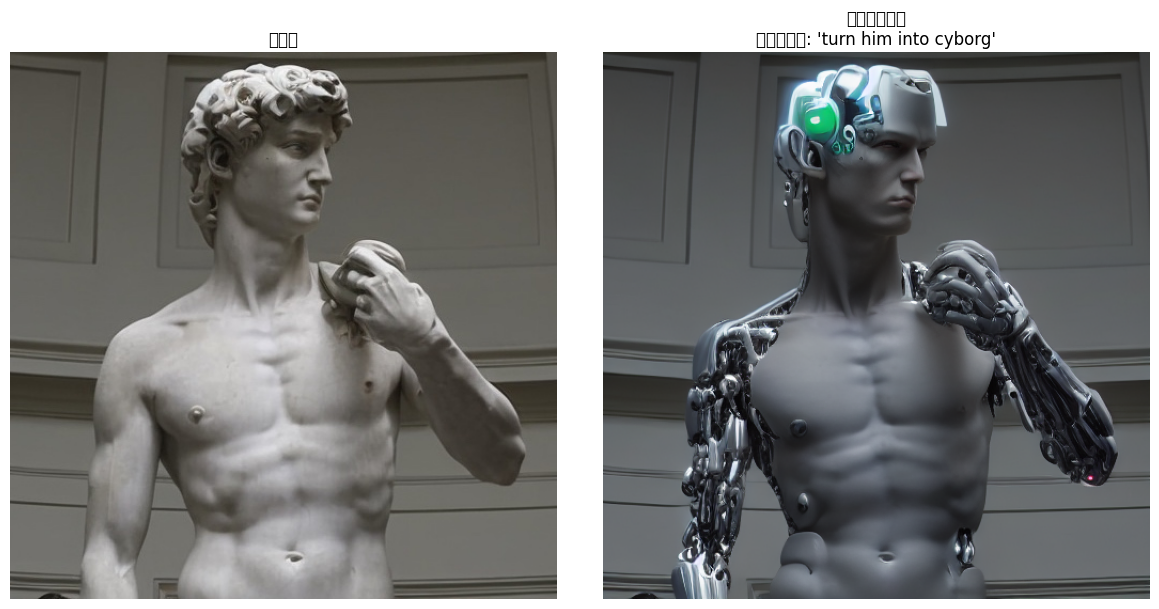

In [6]:
# "彼をサイボーグに変えて"という指示
prompt = "turn him into cyborg"

# 必要なライブラリをインポート
import requests, PIL
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

# --- サンプル画像をダウンロード ---
url = "https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/example.jpg"

def download_image(path_or_url):
    """
    URLまたはローカルパスから画像を読み込む関数

    引数:
        path_or_url: 画像のURLまたはローカルパス
    戻り値:
        PIL.Image: RGB形式の画像
    """
    if isinstance(path_or_url, str) and path_or_url.startswith(("http://", "https://")):
        # URLの場合: インターネットから画像をダウンロード
        image = Image.open(requests.get(path_or_url, stream=True).raw)
    elif os.path.exists(path_or_url):
        # ローカルパスの場合: ファイルから画像を開く
        image = Image.open(path_or_url)
    else:
        # どちらでもない場合: エラーを発生させる
        raise ValueError(f"無効なパスまたはURL: {path_or_url}")

    # EXIFデータに基づいて画像の向きを修正
    image = ImageOps.exif_transpose(image)
    # RGB形式（カラー）に変換して返す
    return image.convert("RGB")

# サンプル画像をダウンロード
image = download_image(url)

# --- 編集プロンプトを設定 ---

# --- 画像編集の実行 ---
result = pipe(
    prompt=prompt,  # 編集指示
    image=image,  # 入力画像
    num_inference_steps=10,  # 生成ステップ数（多いほど高品質だが時間がかかる）
    image_guidance_scale=1.0,  # 元画像への忠実度
    guidance_scale=7.5,  # プロンプトへの忠実度
).images[0]  # 結果の最初の画像を取得

# --- 結果の表示 ---
# 1行2列のサブプロット（2つの画像を横に並べる）
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# 左側: 元画像
ax[0].imshow(image)
ax[0].set_title("元画像")
ax[0].axis("off")

# 右側: 編集後の画像
ax[1].imshow(result)
ax[1].set_title(f"編集後の画像\nプロンプト: '{prompt}'")
ax[1].axis("off")

# レイアウトを調整して表示
plt.tight_layout()
plt.show()

## ステップ5: 自分の画像で編集を試す

Google Driveにアップロードした自分の画像を使って編集してみましょう。

### 使い方
1. Google Driveの`/MyDrive/images/`フォルダに画像をアップロード
2. `prompt`変数に編集内容を英語で記述
3. パラメータを調整（必要に応じて）
4. セルを実行

### プロンプトのコツ
- **具体的に**: "make it dark"より"make the background dark and ominous"の方が良い
- **簡潔に**: 長すぎるプロンプトは避ける
- **英語で**: 日本語より英語の方が精度が高い

### パラメータ調整のヒント
- **元画像を保ちたい**: `image_guidance_scale`を大きく（1.5〜2.0）
- **大胆に変更したい**: `image_guidance_scale`を小さく（0.5〜1.0）
- **プロンプトに忠実に**: `guidance_scale`を大きく（8.0〜10.0）

▶ プロンプト: Make it a Modigliani painting


  0%|          | 0/30 [00:00<?, ?it/s]

▶ プロンプト: Make it a Miro painting


  0%|          | 0/30 [00:00<?, ?it/s]

▶ プロンプト: Make it an Egyptian sculpture


  0%|          | 0/30 [00:00<?, ?it/s]

▶ プロンプト: Make it a marble roman sculptur


  0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipython-input-3374303966.py:47: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3374303966.py:47: UserWarning: Glyph 30011 (\N{CJK UNIFIED IDEOGRAPH-753B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3374303966.py:47: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


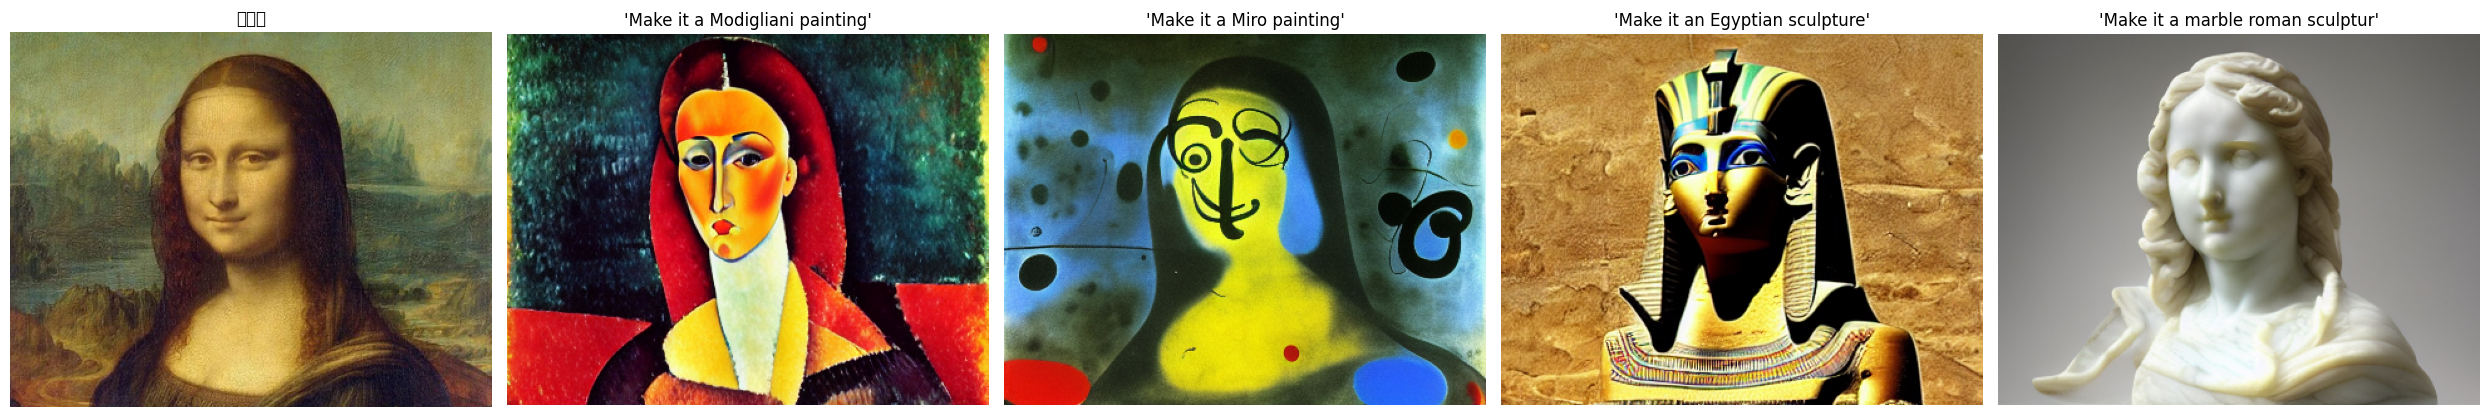

In [ ]:
import matplotlib.pyplot as plt

# --- 自分の画像で画像編集を試す ---

# Google Driveから画像を読み込む
image = download_image("/content/drive/MyDrive/images/07/モナリザ.png")

# --- 編集プロンプトを複数指定 ---
prompts = [
    "Make it a Modigliani painting",      # モディリアーニ風の絵画にして
    "Make it a Miro painting",            # ミロ風の絵画にして
    "Make it an Egyptian sculpture",      # エジプト風の彫刻にして
    "Make it a marble roman sculptur"     # 大理石のローマ風彫刻にして（※typo: sculptur → sculpture）
]


# 結果を保存するリスト
results = []

# 各プロンプトに対して生成
for p in prompts:
    print(f"▶ プロンプト: {p}")
    result = pipe(
        prompt=p,
        image=image,                   # 元画像
        num_inference_steps=30,        # ステップ数
        guidance_scale=7.5,            # テキストへの忠実度
        image_guidance_scale=1.2,      # 元画像への忠実度
    ).images[0]
    results.append((p, result))

# --- 結果の可視化 ---
cols = len(results) + 1  # 元画像 + 各編集結果
fig, axes = plt.subplots(1, cols, figsize=(5 * cols, 5))

# 左端：元画像
axes[0].imshow(image)
axes[0].set_title("元画像")
axes[0].axis("off")

# 右側：編集後の各画像
for i, (p, img) in enumerate(results):
    axes[i + 1].imshow(img)
    axes[i + 1].set_title(f"'{p}'")
    axes[i + 1].axis("off")

plt.tight_layout()
plt.show()


▶ プロンプト: Put them in outer space


  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipython-input-2310468221.py:44: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2310468221.py:44: UserWarning: Glyph 30011 (\N{CJK UNIFIED IDEOGRAPH-753B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2310468221.py:44: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


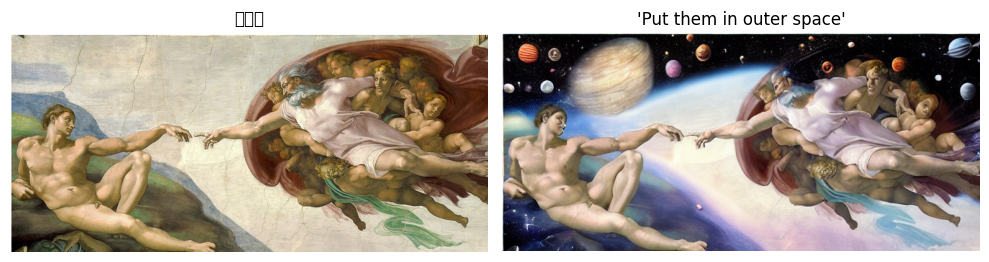

In [ ]:
import matplotlib.pyplot as plt

# --- 自分の画像で画像編集を試す ---

# Google Driveから画像を読み込む
image = download_image("/content/drive/MyDrive/images/07/アダムの創造.png")

# --- 編集プロンプトを複数指定 ---
prompts = [
    "Put them in outer space",        # 彼らを宇宙空間に置いて
]


# 結果を保存するリスト
results = []

# 各プロンプトに対して生成
for p in prompts:
    print(f"▶ プロンプト: {p}")
    result = pipe(
        prompt=p,
        image=image,                   # 元画像
        num_inference_steps=50,        # ステップ数
        guidance_scale=10,            # テキストへの忠実度
        image_guidance_scale=1.5,      # 元画像への忠実度
    ).images[0]
    results.append((p, result))

# --- 結果の可視化 ---
cols = len(results) + 1  # 元画像 + 各編集結果
fig, axes = plt.subplots(1, cols, figsize=(5 * cols, 5))

# 左端：元画像
axes[0].imshow(image)
axes[0].set_title("元画像")
axes[0].axis("off")

# 右側：編集後の各画像
for i, (p, img) in enumerate(results):
    axes[i + 1].imshow(img)
    axes[i + 1].set_title(f"'{p}'")
    axes[i + 1].axis("off")

plt.tight_layout()
plt.show()
